[View in Colaboratory](https://colab.research.google.com/github/krishna-sharma19/sparcs/blob/master/inner_layers_gpu.ipynb)

In [0]:
!wget "https://www.dropbox.com/s/mf5ni8q4kb92yju/Hospital_Inpatient_Discharges__SPARCS_De-Identified___2015.csv?dl=0"


In [9]:
import pandas as pd
!ls -l


total 8
drwxr-xr-x 1 root root 4096 Apr 12 13:51 datalab
-rw-r--r-- 1 root root   92 Apr 12 13:52 stats.csv


In [0]:
!cp Hospital_Inpatient_Discharges__SPARCS_De-Identified___2015.csv?dl=0  sparcs/sparcs-2014.csv

In [0]:
import numpy as np # linear algebra
from sklearn import preprocessing    
import tensorflow as tf
import time
# from SALib.analyze import delta
# from SALib.util import read_param_file
import csv


def cleanAndProcessData(filename):
    patient_data_df = pd.read_csv(filename)
    #patient_data_df = pd.read_csv('../input/Hospital_Inpatient_Discharges__SPARCS_De-Identified___2015.csv')
    X_Full = patient_data_df[['Age Group', 'Gender', 'Race', 'Ethnicity', 'Type of Admission','CCS Diagnosis Code','CCS Procedure Code',  'APR DRG Code', 'APR MDC Code','APR Severity of Illness Code','APR Risk of Mortality']]
    pd.options.mode.chained_assignment = None
    X_Full['Age Group']=pd.factorize(X_Full['Age Group'])[0]
    X_Full['APR Risk of Mortality']=pd.factorize(X_Full['APR Risk of Mortality'])[0]
    X_Full=pd.get_dummies(X_Full, columns=["Race"])
    X_Full=pd.get_dummies(X_Full, columns=["Ethnicity"])
    X_Full=pd.get_dummies(X_Full, columns=["Type of Admission"])
    X_Full=pd.get_dummies(X_Full, columns=["Gender"])
    Y_Full = patient_data_df[['Length of Stay']]
    Y_Full = Y_Full.replace('120 +', 120)
    Y_Full['Length of Stay'] = Y_Full['Length of Stay'].apply(pd.to_numeric)

#     Si = delta.analyze(problem, X_Full, Y_Full, num_resamples=10, conf_level=0.95, print_to_console=False)
#     print(str(Si['delta']))
    return (patient_data_df,X_Full,Y_Full)

In [0]:
def randomSample(patient_data_df,X_Full,Y_Full):
    msk = np.random.rand(len(patient_data_df)) < 0.8
    X_training = X_Full[msk]
    X_testing = X_Full[~msk]

    Y_training = Y_Full[msk]
    Y_testing = Y_Full[~msk]

    from sklearn.preprocessing import MinMaxScaler
    import tensorflow as tf

    # tf.reset_default_graph()
    X_scaler = MinMaxScaler(feature_range=(0, 1))
    Y_scaler = MinMaxScaler(feature_range=(0, 1))

    # Scale both the training inputs and outputs
    X_scaled_training = X_scaler.fit_transform(X_training)
    Y_scaled_training = Y_scaler.fit_transform(Y_training)

    # It's very important that the training and test data are scaled with the same scaler.
    X_scaled_testing = X_scaler.transform(X_testing)
    Y_scaled_testing = Y_scaler.transform(Y_testing)
    return (Y_scaler,Y_testing,(X_scaled_training,Y_scaled_training),(X_scaled_testing ,Y_scaled_testing))


In [0]:
#@title Default title text
def neuralTraining(patient_data_df,X,Y,learning_rate = 0.001,training_epochs = 100, layer_1_nodes = 100, layer_2_nodes = 250, layer_3_nodes = 250 ,layer_4_nodes = 100):
    (Y_scaler,Y_testing,(X_scaled_training, Y_scaled_training), (X_scaled_testing, Y_scaled_testing)) = randomSample(patient_data_df,X,Y)
    # Define how many inputs and outputs are in our neural network
    number_of_inputs = 24
    number_of_outputs = 1
    
    # Section One: Define the layers of the neural network itself

    # Input Layer
    tf.reset_default_graph() 
    with tf.variable_scope('input'):
        X = tf.placeholder(tf.float32, shape=(None, number_of_inputs))

    # Layer 1
    with tf.variable_scope('layer_1'):
        weights = tf.get_variable("weights1", shape=[number_of_inputs, layer_1_nodes],
                                  initializer=tf.contrib.layers.xavier_initializer())
        biases = tf.get_variable(name="biases1", shape=[layer_1_nodes], initializer=tf.zeros_initializer())
        layer_1_output = tf.nn.relu(tf.matmul(X, weights) + biases)

    # Layer 2
    with tf.variable_scope('layer_2'):
        weights = tf.get_variable("weights2", shape=[layer_1_nodes, layer_2_nodes],
                                  initializer=tf.contrib.layers.xavier_initializer())
        biases = tf.get_variable(name="biases2", shape=[layer_2_nodes], initializer=tf.zeros_initializer())
        layer_2_output = tf.nn.relu(tf.matmul(layer_1_output, weights) + biases)

    # Layer 3
    with tf.variable_scope('layer_3'):
        weights = tf.get_variable("weights3", shape=[layer_2_nodes, layer_3_nodes],
                                  initializer=tf.contrib.layers.xavier_initializer())
        biases = tf.get_variable(name="biases3", shape=[layer_3_nodes], initializer=tf.zeros_initializer())
        layer_3_output = tf.nn.relu(tf.matmul(layer_2_output, weights) + biases)

    # Layer 4
    with tf.variable_scope('layer_4'):
        weights = tf.get_variable("weights4", shape=[layer_3_nodes, layer_4_nodes],
                                  initializer=tf.contrib.layers.xavier_initializer())
        biases = tf.get_variable(name="biases4", shape=[layer_4_nodes], initializer=tf.zeros_initializer())
        layer_4_output = tf.nn.relu(tf.matmul(layer_3_output, weights) + biases)

    # Output Layer
    with tf.variable_scope('output'):
        weights = tf.get_variable("weights5", shape=[layer_4_nodes, number_of_outputs],
                                  initializer=tf.contrib.layers.xavier_initializer())
        biases = tf.get_variable(name="biases5", shape=[number_of_outputs], initializer=tf.zeros_initializer())
        prediction = tf.matmul(layer_4_output, weights) + biases

    # Section Two: Define the cost function of the neural network that will measure prediction accuracy during training

    with tf.variable_scope('cost'):
        Y = tf.placeholder(tf.float32, shape=(None, 1))
#         cost = tf.reduce_mean(tf.squared_difference(prediction, Y))
        lasso_param = tf.constant(0.001)
#         heavyside_step = tf.truediv(1., tf.add(1., tf.exp(tf.multiply(-50., tf.subtract(tf.reduce_sum(weights), lasso_param)))))
        regularization_param = tf.multiply(lasso_param, tf.reduce_sum(tf.abs(weights)))
#         loss = tf.add(tf.reduce_mean(tf.square(y_target - model_output)), regularization_param)
        cost = tf.add(tf.reduce_mean(tf.squared_difference(prediction, Y)),regularization_param)
    # Section Three: Define the optimizer function that will be run to optimize the neural network

    with tf.variable_scope('train'):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    # Create a summary operation to log the progress of the network
    with tf.variable_scope('logging'):
        tf.summary.scalar('current_cost', cost)
        summary = tf.summary.merge_all()

    rmsds= []
    arr = np.asarray(Y_testing['Length of Stay'])
    arr = np.transpose(np.asmatrix(arr))

    saver = tf.train.Saver()
    with tf.Session() as session:
        # When loading from a checkpoint, don't initialize the variables!
        session.run(tf.global_variables_initializer())
        for epoch in range(training_epochs):

            # Feed in the training data and do one step of neural network training
            session.run(optimizer, feed_dict={X: X_scaled_training, Y: Y_scaled_training})

            # Every 3 training steps, log our progress
            if epoch % 3 == 0:
                # Get the current accuracy scores by running the "cost" operation on the training and test data sets
                training_cost, training_summary = session.run([cost, summary], feed_dict={X: X_scaled_training, Y:Y_scaled_training})
                testing_cost, testing_summary = session.run([cost, summary], feed_dict={X: X_scaled_testing, Y:Y_scaled_testing})

                Y_predicted_scaled = session.run(prediction, feed_dict={X: X_scaled_testing})

                Y_predicted = Y_scaler.inverse_transform(Y_predicted_scaled)

                rmsd = np.sqrt(np.mean(np.asarray((arr - Y_predicted)) ** 2))
                Y_predicted = Y_predicted.astype(np.int64, copy=False)
#                 import csv
#                 with open(r'stats.csv', 'a') as f:
#                     writer = csv.writer(f)
#                     writer.writerow([learning_rate,training_epochs, layer_1_nodes, layer_2_nodes, layer_3_nodes  ,layer_4_nodes,rmsd])


                # Print the current training status to the screen
                print("Epoch: {} - Training Cost: {}  Testing Cost: {} RMSD: {}".format(epoch, training_cost, testing_cost, rmsd))

            # Training is now complete!

            # Get the final accuracy scores by running the "cost" operation on the training and test data sets
            final_training_cost = session.run(cost, feed_dict={X: X_scaled_training, Y: Y_scaled_training})
            final_testing_cost = session.run(cost, feed_dict={X: X_scaled_testing, Y: Y_scaled_testing})

        print("Final Training cost: {}".format(final_training_cost))
        print("Final Testing cost: {}".format(final_testing_cost))

        # print(arr)
        # print(Y_predicted)
        import matplotlib.pyplot as plt

        # np.histogram(arr-Y_predicted)
        plt.hist(arr - Y_predicted)
        plt.show()

        with open(r'stats_outer.csv', 'a') as f:
            writer = csv.writer(f)
            writer.writerow([learning_rate,training_epochs, layer_1_nodes, layer_2_nodes, layer_3_nodes  ,layer_4_nodes, rmsd, training_cost, testing_cost])





In [0]:
#your code here    
# import tensorflow as tf
# with open(r'stats.csv','a') as f:
#     writer = csv.writer(f)
#     writer.writerow(["learning_rate","training_epochs","layer_1_nodes", "layer_2_nodes", "layer_3_nodes"  ,"layer_4_nodes","rmsd", "traiing loss", "testing los"])


device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
patient_data_df,X,Y = cleanAndProcessData("Hospital_Inpatient_Discharges__SPARCS_De-Identified___2015.csv?dl=0");

with tf.device('/gpu:0'):
  neuralTraining(patient_data_df,X,Y,0.02,1000, 100,100,100,100)
#   for i in range(250,500,25):
#       for j in range(100,500,25):
#           print("layer 1 nodes",i,250,250,j)
#           start = time.clock()
#           neuralTraining(patient_data_df,X,Y,0.01,15, 100,i, j ,100)
#           print("time taken:",time.clock() - start)
# import sys



# sys.path.append('../..')


# Read the parameter range file and generate samples
# Since this is "given data", the bounds in the parameter file will not be used
# but the columns are still expected
# problem = read_param_file('../../SALib/test_functions/params/Ishigami.txt')
# X = np.loadtxt('model_input.txt')
# Y = np.loadtxt('model_output.txt')

# Perform the sensitivity analysis using the model output
# Specify which column of the output file to analyze (zero-indexed)
# Si = delta.analyze(problem, X, Y, num_resamples=10, conf_level=0.95, print_to_console=False)
# Returns a dictionary with keys 'delta', 'delta_conf', 'S1', 'S1_conf'
# print(str(Si['delta']))




Found GPU at: /device:GPU:0


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Epoch: 0 - Training Cost: 0.11525676399469376  Testing Cost: 0.11574401706457138 RMSD: 38.458436891769686
Epoch: 3 - Training Cost: 0.013850923627614975  Testing Cost: 0.014023296535015106 RMSD: 8.878317279020315
Epoch: 6 - Training Cost: 0.021216653287410736  Testing Cost: 0.02142699435353279 RMSD: 14.569116873501534
Epoch: 9 - Training Cost: 0.010002728551626205  Testing Cost: 0.010156350210309029 RMSD: 8.214099754363748
Epoch: 12 - Training Cost: 0.010297841392457485  Testing Cost: 0.01042296551167965 RMSD: 8.969390354703634
Epoch: 15 - Training Cost: 0.009761448949575424  Testing Cost: 0.009926049038767815 RMSD: 8.830345957911465
Epoch: 18 - Training Cost: 0.00912200752645731  Testing Cost: 0.00928273145109415 RMSD: 8.515500243607782
Epoch: 21 - Training Cost: 0.00875585526227951  Testing Cost: 0.008887996897101402 RMSD: 8.392020096244321
Epoch: 24 - Training Cost: 0.007951553910970688  Testing Cost: 0.008095566183328629 RMSD: 7.973260934869912
Epoch: 27 - Training Cost: 0.00793472

Epoch: 126 - Training Cost: 0.005297434516251087  Testing Cost: 0.0054410407319664955 RMSD: 7.634078719480824
Epoch: 129 - Training Cost: 0.005276106297969818  Testing Cost: 0.005419149529188871 RMSD: 7.624458177298782
Epoch: 132 - Training Cost: 0.005248013883829117  Testing Cost: 0.005391230806708336 RMSD: 7.615293614177456
Epoch: 135 - Training Cost: 0.005196010693907738  Testing Cost: 0.00533883273601532 RMSD: 7.605621638667693
Epoch: 138 - Training Cost: 0.005165796261280775  Testing Cost: 0.005308506544679403 RMSD: 7.596593433861396
Epoch: 141 - Training Cost: 0.00514995027333498  Testing Cost: 0.0052922856993973255 RMSD: 7.58715686478654
Epoch: 144 - Training Cost: 0.005116025917232037  Testing Cost: 0.005258586257696152 RMSD: 7.578782163109078
Epoch: 147 - Training Cost: 0.005086405668407679  Testing Cost: 0.005228186957538128 RMSD: 7.569003294431397
Epoch: 150 - Training Cost: 0.005084132310003042  Testing Cost: 0.005225722678005695 RMSD: 7.560081969844332
Epoch: 153 - Trainin

Epoch: 252 - Training Cost: 0.00454649468883872  Testing Cost: 0.004680865444242954 RMSD: 7.399779150318653
Epoch: 255 - Training Cost: 0.004538821522146463  Testing Cost: 0.004674173425883055 RMSD: 7.399537374326452
Epoch: 258 - Training Cost: 0.00450541265308857  Testing Cost: 0.00464035477489233 RMSD: 7.397371008865102
Epoch: 261 - Training Cost: 0.004524965770542622  Testing Cost: 0.004659297410398722 RMSD: 7.395952150579465
Epoch: 264 - Training Cost: 0.004495194647461176  Testing Cost: 0.00462957052513957 RMSD: 7.394536366992298
Epoch: 267 - Training Cost: 0.0044905394315719604  Testing Cost: 0.0046259197406470776 RMSD: 7.3950648304805355
Epoch: 270 - Training Cost: 0.00447416864335537  Testing Cost: 0.0046089948154985905 RMSD: 7.392414321261113
Epoch: 273 - Training Cost: 0.00447027338668704  Testing Cost: 0.0046043796464800835 RMSD: 7.39104530223885
Epoch: 276 - Training Cost: 0.004470227751880884  Testing Cost: 0.004604353103786707 RMSD: 7.3895702495752165
Epoch: 279 - Trainin

Epoch: 378 - Training Cost: 0.004172435961663723  Testing Cost: 0.004305609501898289 RMSD: 7.339931129255598
Epoch: 381 - Training Cost: 0.004160905256867409  Testing Cost: 0.004293713252991438 RMSD: 7.337790845293582
Epoch: 384 - Training Cost: 0.004152209497988224  Testing Cost: 0.004285068716853857 RMSD: 7.336501922454228
Epoch: 387 - Training Cost: 0.004164314363151789  Testing Cost: 0.004296907689422369 RMSD: 7.334766886476775
Epoch: 390 - Training Cost: 0.004147939849644899  Testing Cost: 0.004279996734112501 RMSD: 7.332953289964302
Epoch: 393 - Training Cost: 0.0041600000113248825  Testing Cost: 0.0042920284904539585 RMSD: 7.331407203435076
Epoch: 396 - Training Cost: 0.004152071662247181  Testing Cost: 0.0042841676622629166 RMSD: 7.329844492153076
Epoch: 399 - Training Cost: 0.004132643807679415  Testing Cost: 0.004264391493052244 RMSD: 7.328409350161056
Epoch: 402 - Training Cost: 0.0041323271580040455  Testing Cost: 0.0042641619220376015 RMSD: 7.326755325920116
Epoch: 405 - T

Epoch: 504 - Training Cost: 0.00395334092900157  Testing Cost: 0.004082468803972006 RMSD: 7.253768457268121
Epoch: 507 - Training Cost: 0.003949018195271492  Testing Cost: 0.004078327212482691 RMSD: 7.252023223259032
Epoch: 510 - Training Cost: 0.00392947206273675  Testing Cost: 0.004058073740452528 RMSD: 7.248349784007326
Epoch: 513 - Training Cost: 0.003951018210500479  Testing Cost: 0.00407981825992465 RMSD: 7.246064690446038
Epoch: 516 - Training Cost: 0.00391748920083046  Testing Cost: 0.004046117886900902 RMSD: 7.243506502260577
Epoch: 519 - Training Cost: 0.003937439061701298  Testing Cost: 0.004066134802997112 RMSD: 7.241404639512036
Epoch: 522 - Training Cost: 0.003912679385393858  Testing Cost: 0.004041135311126709 RMSD: 7.238564899238847
Epoch: 525 - Training Cost: 0.003914168104529381  Testing Cost: 0.004042126704007387 RMSD: 7.235922601825874
Epoch: 528 - Training Cost: 0.00392903434112668  Testing Cost: 0.004057156853377819 RMSD: 7.233624699422586
Epoch: 531 - Training Co

Epoch: 630 - Training Cost: 0.003778749378398061  Testing Cost: 0.003906588070094585 RMSD: 7.166072843924504
Epoch: 633 - Training Cost: 0.003776741912588477  Testing Cost: 0.0039045403245836496 RMSD: 7.164414400956481
Epoch: 636 - Training Cost: 0.0037532278802245855  Testing Cost: 0.003880584379658103 RMSD: 7.162078802609012
Epoch: 639 - Training Cost: 0.003767634043470025  Testing Cost: 0.003895327914506197 RMSD: 7.161212869832697
Epoch: 642 - Training Cost: 0.0037518753670156  Testing Cost: 0.003879246534779668 RMSD: 7.1596274683152785
Epoch: 645 - Training Cost: 0.003758144797757268  Testing Cost: 0.0038855785969644785 RMSD: 7.1585455506263855
Epoch: 648 - Training Cost: 0.0037584491074085236  Testing Cost: 0.003885999321937561 RMSD: 7.157262164062252


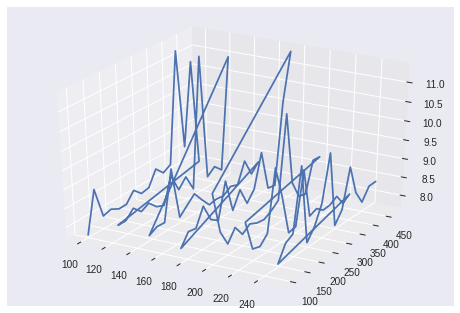

,learning_rate,training_epochs,layer_1_nodes,layer_2_nodes,layer_3_nodes,layer_4_nodes,rmsd
0,0.01,15,100,100,100,100,7.743407
1,0.01,15,100,100,125,100,8.839276
2,0.01,15,100,100,150,100,8.010909
3,0.01,15,100,100,175,100,8.074045
4,0.01,15,100,100,200,100,7.962550
5,0.01,15,100,100,225,100,7.970510
6,0.01,15,100,100,250,100,8.233571
7,0.01,15,100,100,275,100,8.030148
8,0.01,15,100,100,300,100,8.072925
9,0.01,15,100,100,325,100,8.471829


In [17]:
patient_data_df = pd.read_csv("stats.csv")
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.gca(projection='3d')
x = patient_data_df.layer_2_nodes
y = patient_data_df.layer_3_nodes
z = patient_data_df.rmsd
ax.plot(x, y, z, label='parametric curve')
plt.show()


patient_data_df

In [14]:
cat stats.csv

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'stats_outer2.csv'})
uploaded.SetContentFile('stats.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

FileNotFoundError: ignored

In [0]:
https://www.dropbox.com/h

In [4]:
#model for prediction
mms = preprocessing.MinMaxScaler()
rbf = get_model(path_to_model)


n_epochs = 200
train_errors = []
non_train_errors = []
test_errors = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in tqdm.tqdm(range(n_epochs)):

        _, train_err, summ = sess.run([train_step, loss, summaries],
                                feed_dict={x_: parrots, y_: liters})
        summary_writer.add_summary(summ, i)
        train_errors.append(train_err)

        _, non_train_err, = sess.run([train_step_nonlin, nonlin_loss],
                                      feed_dict={x_: parrots, y_: liters})
        non_train_errors.append(non_train_err)


    plt.plot(list(range(n_epochs)), train_errors, label='train_lin')
    plt.plot(list(range(n_epochs)), non_train_errors, label='train_nonlin')
    plt.legend()
    print(train_errors[:10])
    print(non_train_errors[:10])
    plt.show()

    plt.scatter(parrots, liters, label='actual data')
    plt.plot(parrots, sess.run(lin_model, feed_dict={x_: parrots}), label='linear (tf)')
    plt.plot(parrots, sess.run(nonlin_model, feed_dict={x_: parrots}), label='nonlinear (tf)')
    plt.plot(parrots, rbf.predict(mms.fit_transform(parrots)), label='rbf (sklearn)')
    plt.legend()
    plt.show()

NameError: ignored